In [ ]:
import numpy as np
import math
import random
from collections import Counter
import h5py
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix, silhouette_score
from sklearn.preprocessing import StandardScaler
import umap
import string

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({
    # --- LaTeX-style text ---
    "text.usetex": True,                     # requires LaTeX installed
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"], # same as LaTeX default

    # --- Font sizes ---
    "axes.labelsize": 9,
    "font.size": 9,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,

    # --- Line / axis styling ---
    "axes.linewidth": 0.8,
    "lines.linewidth": 1.0,
    "lines.markersize": 3,

    # --- Figure / save defaults ---
    "figure.dpi": 150,
    "savefig.dpi": 600,
    "savefig.bbox": "tight",
})
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"]  = 42

from cycler import cycler
mpl.rcParams["axes.prop_cycle"] = cycler("color", [
    "#1f77b4", "#ff7f0e", "#2ca02c",
    "#d62728", "#9467bd", "#8c564b"
])

def nice_axes(figsize):
    fig, ax = plt.subplots(figsize=figsize)

    # Remove top/right border
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Inward ticks, only bottom/left
    ax.tick_params(
        direction="in",
        which="both",
        top=False,
        right=False,
    )

    return fig, ax

2025-12-03 21:43:02.225270: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Path Gravity Spy HDF5 file
h5_path = "trainingsetv1d0.h5"

# Data selection
# Use only 1s and 2s views to simplify the input
durations  = ("1.0.png", "2.0.png")

with h5py.File(h5_path, "r") as f:
    labels = list(f.keys())
    print("Labels in HDF5:", labels)
    print("Number of labels:", len(labels))
    print("First few labels:", labels[:5])

    # For 2-3 labels, print the subgroup names (these are the splits)
    for lbl in labels[:3]:
        print(f"\nLabel: {lbl}")
        print("  subgroups:", list(f[lbl].keys()))

# Use a subset of Gravity Spy classes
desired_classes = [
    "1080Lines",
    "1400Ripples",
    "Air_Compressor",
    "Chirp",
    "Helix",
    "Paired_Doves",
    "Power_Line",
    "Scratchy",
    "Koi_Fish",
    "Violin_Mode",
    "Scattered_Light",
    "Low_Frequency_Lines"
]

# Training settings
batch_size = 64
num_epochs = 10

# Learning-rate settings
base_lr         = 1e-3     # target LR after warm-up
warmup_start_lr = 1e-4     # LR at epoch 1
warmup_epochs   = 3        # number of warm-up epochs

lambda_cls = 0.3           # weight for classification loss
latent_dim = 128           # size of embedding vector

device = torch.device("cpu")

# Reproducibility
seed = 7
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

Labels in HDF5: ['1080Lines', '1400Ripples', 'Air_Compressor', 'Blip', 'Chirp', 'Extremely_Loud', 'Helix', 'Koi_Fish', 'Light_Modulation', 'Low_Frequency_Burst', 'Low_Frequency_Lines', 'No_Glitch', 'None_of_the_Above', 'Paired_Doves', 'Power_Line', 'Repeating_Blips', 'Scattered_Light', 'Scratchy', 'Tomte', 'Violin_Mode', 'Wandering_Line', 'Whistle']
Number of labels: 22
First few labels: ['1080Lines', '1400Ripples', 'Air_Compressor', 'Blip', 'Chirp']

Label: 1080Lines
  subgroups: ['test', 'train', 'validation']

Label: 1400Ripples
  subgroups: ['test', 'train', 'validation']

Label: Air_Compressor
  subgroups: ['test', 'train', 'validation']


In [3]:
def data_prep(h5_path, split, durations, top_k=None, allowed_labels=None, verbose=True):
    """
    Load Gravity Spy spectrograms for a given split, stacking multiple durations as channels.

    You can either:
      - specify `allowed_labels` (list of class names to keep), OR
      - specify `top_k` (keep the top_k most frequent labels).
      If both are None, all labels in the split are used.

    Returns:
        X: np.ndarray, shape (N, C, H, W)
        y_str: np.ndarray, shape (N,)  (string labels)
        y_idx: np.ndarray, shape (N,)  (integer labels)
        label_to_idx: dict {label: int}
    """
    X, y = [], []

    with h5py.File(h5_path, "r") as f:
        # Count samples per label in this split
        counts = {}
        for label in f.keys():
            if split in f[label]:
                counts[label] = len(f[label][split].keys())

        if verbose:
            print(f"[load] found {len(counts)} labels in split '{split}'")

        # Decide which labels to keep
        if allowed_labels is not None:
            # keep only intersection
            selected_labels = [lbl for lbl in allowed_labels if lbl in counts]
            missing = [lbl for lbl in allowed_labels if lbl not in counts]
            if verbose:
                print("[load] using explicit allowed_labels")
                print("       present:", selected_labels)
                if missing:
                    print("       WARNING: these requested labels are NOT in this split:", missing)
        elif top_k is not None:
            selected_labels = [lbl for lbl, _ in Counter(counts).most_common(top_k)]
            if verbose:
                print(f"[load] keeping top {top_k} labels by frequency:", selected_labels)
        else:
            selected_labels = list(counts.keys())
            if verbose:
                print("[load] using ALL labels in this split")

        n_skipped_missing = 0

        for label in selected_labels:
            split_group = f[label][split]
            for gid, sample_group in split_group.items():
                imgs = []
                missing_dur = False
                for dur in durations:
                    if dur not in sample_group:
                        missing_dur = True
                        break
                    img = sample_group[dur][...].squeeze(0)  # (H, W)
                    imgs.append(img)
                if missing_dur:
                    n_skipped_missing += 1
                    continue

                stack = np.stack(imgs, axis=0).astype(np.float32)  # (C, H, W)
                X.append(stack)
                y.append(label)

        if verbose:
            print(f"[load] collected {len(X)} samples; skipped {n_skipped_missing} with missing durations")

    X = np.stack(X, axis=0)           # (N, C, H, W)
    y_str = np.array(y)               # (N,)

    kept_sorted = sorted(list(set(y_str.tolist())))
    label_to_idx = {c: i for i, c in enumerate(kept_sorted)}
    y_idx = np.array([label_to_idx[yy] for yy in y_str], dtype=np.int64)

    if verbose:
        print("[load] X shape:", X.shape)
        print("[load] y_str shape:", y_str.shape)
        print("[load] kept label_to_idx:", label_to_idx)

    return X, y_str, y_idx, label_to_idx

In [4]:
# TRAIN split
X_train, y_train_str, y_train_idx, label_to_idx = data_prep(
    h5_path=h5_path,
    split="train",
    durations=durations,
    top_k=None,
    allowed_labels=desired_classes,
    verbose=True,
)

idx_to_label = {v: k for k, v in label_to_idx.items()}
num_classes  = len(label_to_idx)

class_counts = np.bincount(y_train_idx, minlength=num_classes).astype(np.float32)
class_weights = 1.0 / np.maximum(class_counts, 1.0)
class_weights = class_weights * (num_classes / class_weights.sum())  # normalise nicely

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32, device=device)

print("Train label_to_idx:", label_to_idx)

# VALIDATION split
X_val, y_val_str, y_val_idx, _ = data_prep(
    h5_path=h5_path,
    split="validation",
    durations=durations,
    top_k=None,
    allowed_labels=desired_classes,
    verbose=True,
)

# TEST split
X_test, y_test_str, y_test_idx, _ = data_prep(
    h5_path=h5_path,
    split="test",
    durations=durations,
    top_k=None,
    allowed_labels=desired_classes,
    verbose=True,
)

[load] found 22 labels in split 'train'
[load] using explicit allowed_labels
       present: ['1080Lines', '1400Ripples', 'Air_Compressor', 'Chirp', 'Helix', 'Paired_Doves', 'Power_Line', 'Scratchy', 'Koi_Fish', 'Violin_Mode', 'Scattered_Light', 'Low_Frequency_Lines']
[load] collected 2807 samples; skipped 0 with missing durations
[load] X shape: (2807, 2, 140, 170)
[load] y_str shape: (2807,)
[load] kept label_to_idx: {'1080Lines': 0, '1400Ripples': 1, 'Air_Compressor': 2, 'Chirp': 3, 'Helix': 4, 'Koi_Fish': 5, 'Low_Frequency_Lines': 6, 'Paired_Doves': 7, 'Power_Line': 8, 'Scattered_Light': 9, 'Scratchy': 10, 'Violin_Mode': 11}
Train label_to_idx: {'1080Lines': 0, '1400Ripples': 1, 'Air_Compressor': 2, 'Chirp': 3, 'Helix': 4, 'Koi_Fish': 5, 'Low_Frequency_Lines': 6, 'Paired_Doves': 7, 'Power_Line': 8, 'Scattered_Light': 9, 'Scratchy': 10, 'Violin_Mode': 11}
[load] found 22 labels in split 'validation'
[load] using explicit allowed_labels
       present: ['1080Lines', '1400Ripples', 'A

In [ ]:
# Apply global statistics
X_mean = X_train.mean()
X_std  = X_train.std() + 1e-8

X_train = (X_train - X_mean) / X_std
X_val   = (X_val   - X_mean) / X_std
X_test  = (X_test  - X_mean) / X_std

In [6]:
# ---- Convert to tensors ----
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train_idx)

X_val_t   = torch.from_numpy(X_val)
y_val_t   = torch.from_numpy(y_val_idx)

X_test_t  = torch.from_numpy(X_test)
y_test_t  = torch.from_numpy(y_test_idx)

num_classes = len(desired_classes)      # needed for classifier head

# ---- Simple augmentation function for training ----
def simple_augmentation(x, max_shift=2, noise_std=0.01):
    """
    x: torch.Tensor of shape (C, H, W)
    Applies a small random shift and Gaussian noise.
    """
    # random small roll in time/frequency
    if max_shift > 0:
        shift_h = random.randint(-max_shift, max_shift)
        shift_w = random.randint(-max_shift, max_shift)
        x = torch.roll(x, shifts=(shift_h, shift_w), dims=(1, 2))

    # light Gaussian noise
    if noise_std > 0:
        x = x + noise_std * torch.randn_like(x)

    return x

class GlitchDataset(Dataset):
    def __init__(self, X, y, transform=None):
        """
        X: torch.Tensor (N, C, H, W)
        y: torch.Tensor (N,)
        transform: callable taking x -> x (for augmentations)
        """
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        if self.transform is not None:
            x = self.transform(x)
        return x, y

# Train: augmentation ON
train_dataset = GlitchDataset(
    X_train_t, y_train_t,
    transform=lambda img: simple_augmentation(img)
)

# Validation / Test: NO augmentation
val_dataset  = GlitchDataset(X_val_t,  y_val_t,  transform=None)
test_dataset = GlitchDataset(X_test_t, y_test_t, transform=None)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

print("N train:", len(train_dataset), "N val:", len(val_dataset), "N test:", len(test_dataset))

N train: 2807 N val: 602 N test: 602


In [7]:
class ConvAEWithClassifier(nn.Module):
    def __init__(self, in_ch=len(durations), latent_dim=latent_dim, base=32, num_classes=num_classes):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            # Block 1
            nn.Conv2d(in_ch, base, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base, base, kernel_size=3, stride=2, padding=1),  # downsample

            # Block 2
            nn.Conv2d(base, base * 2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base * 2, base * 2, kernel_size=3, stride=2, padding=1),  # downsample

            # Block 3
            nn.Conv2d(base * 2, base * 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base * 4, base * 4, kernel_size=3, stride=2, padding=1),  # downsample
            nn.ReLU(inplace=True),
        )

        # For Gravity Spy 140x170 with 3 stride-2 downsamples:
        # H, W -> (18, 22)
        self.enc_out_channels = base * 4
        self.enc_out_h = 18
        self.enc_out_w = 22
        enc_out_dim = self.enc_out_channels * self.enc_out_h * self.enc_out_w

        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)

        # Small classifier head on latent
        self.classifier = nn.Linear(latent_dim, num_classes)

        # Decoder: latent -> feature map -> upsample back to original size
        self.fc_dec = nn.Linear(latent_dim, enc_out_dim)

        self.decoder_conv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),
            nn.Conv2d(self.enc_out_channels, base * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),
            nn.Conv2d(base * 2, base, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),
            nn.Conv2d(base, in_ch, kernel_size=3, padding=1),
        )

    def encode(self, x):
        h = self.encoder(x)
        h_flat = self.flatten(h)
        z = self.fc_mu(h_flat)
        return z

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(-1, self.enc_out_channels, self.enc_out_h, self.enc_out_w)
        x_rec = self.decoder_conv(h)
        # Crop to original size (140x170) if slightly larger due to upsampling
        x_rec = x_rec[:, :, :140, :170]
        return x_rec

    def forward(self, x):
        z = self.encode(x)
        x_rec = self.decode(z)
        logits = self.classifier(z)
        return x_rec, logits, z

In [ ]:
model = ConvAEWithClassifier(
    in_ch=len(durations),
    latent_dim=latent_dim,
    base=32,
    num_classes=num_classes
).to(device)

recon_criterion = nn.L1Loss()
cls_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Start optimizer at warm-up LR
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=warmup_start_lr,
    weight_decay=1e-5,
)

# LR scheduler: only really used AFTER warm-up
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.3,      # multiply LR by 0.3 on plateau
    patience=2,      # epochs to wait with no improvement
    min_lr=1e-5
)

print(model)

ConvAEWithClassifier(
  (encoder): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_mu): Linear(in_features=50688, out_features=128, bias=True)
  (classifier): Linear(in_features=128, out_features=12, bias=True)
  (fc_dec): Linear(in_features=128, out_features=50688, bias=True)
  (decoder_conv): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1,

In [ ]:
train_total_losses = []
train_recon_losses = []
train_cls_losses   = []

eval_total_losses = []
eval_recon_losses = []
eval_cls_losses   = []

val_accuracies    = []

for epoch in range(num_epochs):
    # ===== TRAINING =====
    model.train()
    running_total = 0.0
    running_recon = 0.0
    running_cls   = 0.0
    n_train       = 0

    for xb, yb in train_loader:
        xb = xb.to(device, dtype=torch.float32)
        yb = yb.to(device, dtype=torch.long)

        optimizer.zero_grad()

        out = model(xb)
        if isinstance(out, tuple) and len(out) == 3:
            recon_batch, logits, _ = out
        else:
            recon_batch, logits = out

        recon_loss = recon_criterion(recon_batch, xb)
        cls_loss   = cls_criterion(logits, yb)
        loss       = recon_loss + lambda_cls * cls_loss

        loss.backward()
        optimizer.step()

        bs = xb.size(0)
        running_total += loss.item()       * bs
        running_recon += recon_loss.item() * bs
        running_cls   += cls_loss.item()   * bs
        n_train       += bs

    epoch_train_total = running_total / n_train
    epoch_train_recon = running_recon / n_train
    epoch_train_cls   = running_cls   / n_train

    train_total_losses.append(epoch_train_total)
    train_recon_losses.append(epoch_train_recon)
    train_cls_losses.append(epoch_train_cls)

    # ===== EVALUATION =====
    model.eval()
    eval_total = 0.0
    eval_recon = 0.0
    eval_cls   = 0.0
    n_eval     = 0

    correct = 0
    total   = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device, dtype=torch.float32)
            yb = yb.to(device, dtype=torch.long)

            out = model(xb)
            if isinstance(out, tuple) and len(out) == 3:
                recon_batch, logits, _ = out
            else:
                recon_batch, logits = out

            recon_loss = recon_criterion(recon_batch, xb)
            cls_loss   = cls_criterion(logits, yb)
            loss       = recon_loss + lambda_cls * cls_loss

            bs = xb.size(0)
            eval_total += loss.item()       * bs
            eval_recon += recon_loss.item() * bs
            eval_cls   += cls_loss.item()   * bs
            n_eval     += bs

            preds = torch.argmax(logits, dim=1)
            correct += (preds == yb).sum().item()
            total   += bs

    epoch_eval_total = eval_total / n_eval
    epoch_eval_recon = eval_recon / n_eval
    epoch_eval_cls   = eval_cls   / n_eval
    val_acc          = correct / total if total > 0 else 0.0

    eval_total_losses.append(epoch_eval_total)
    eval_recon_losses.append(epoch_eval_recon)
    eval_cls_losses.append(epoch_eval_cls)
    val_accuracies.append(val_acc)

    # ----- Warm-up + scheduler -----
    if epoch < warmup_epochs:
        # Linear warm-up from warmup_start_lr -> base_lr
        t = (epoch + 1) / warmup_epochs
        new_lr = warmup_start_lr + t * (base_lr - warmup_start_lr)
        for param_group in optimizer.param_groups:
            param_group["lr"] = new_lr
    else:
        # After warm-up, let ReduceLROnPlateau handle LR
        scheduler.step(epoch_eval_total)

    current_lr = optimizer.param_groups[0]["lr"]

    print(
        f"Epoch {epoch+1}/{num_epochs} "
        f"- train_total_loss={epoch_train_total:.4f} "
        f"- eval_total_loss={epoch_eval_total:.4f} "
        f"- val_acc={val_acc:.3f} "
        f"- lr={current_lr:.2e}"
    )

Epoch 1/30 - train_total_loss=0.8509 - eval_total_loss=0.4497 - val_acc=0.970 - lr=2.80e-04
Epoch 2/30 - train_total_loss=0.4363 - eval_total_loss=0.3849 - val_acc=0.982 - lr=4.60e-04
Epoch 3/30 - train_total_loss=0.3893 - eval_total_loss=0.3847 - val_acc=0.975 - lr=6.40e-04
Epoch 4/30 - train_total_loss=0.3849 - eval_total_loss=0.3720 - val_acc=0.988 - lr=8.20e-04
Epoch 5/30 - train_total_loss=0.3664 - eval_total_loss=0.3558 - val_acc=0.995 - lr=1.00e-03
Epoch 6/30 - train_total_loss=0.3548 - eval_total_loss=0.3802 - val_acc=0.987 - lr=1.00e-03
Epoch 7/30 - train_total_loss=0.3830 - eval_total_loss=0.3705 - val_acc=0.992 - lr=1.00e-03
Epoch 8/30 - train_total_loss=0.3779 - eval_total_loss=0.3771 - val_acc=0.985 - lr=1.00e-03
Epoch 9/30 - train_total_loss=0.3659 - eval_total_loss=0.3658 - val_acc=0.978 - lr=1.00e-03
Epoch 10/30 - train_total_loss=0.3431 - eval_total_loss=0.3572 - val_acc=0.993 - lr=1.00e-03
Epoch 11/30 - train_total_loss=0.3356 - eval_total_loss=0.3536 - val_acc=0.993 

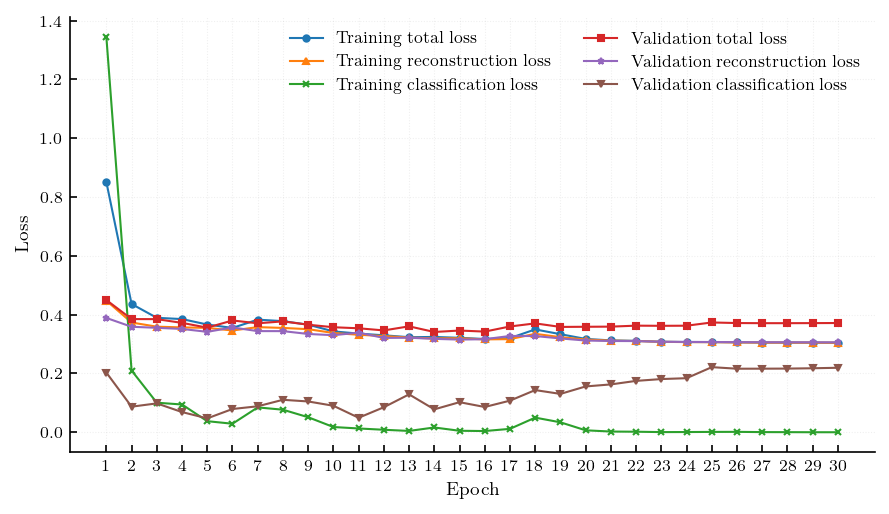

In [ ]:
epochs = range(1, len(train_total_losses) + 1)

fig, ax = nice_axes(figsize=(6, 3.5))

ax.plot(epochs, train_total_losses,  marker="o", label=r"Training total loss")
ax.plot(epochs, train_recon_losses,  marker="^", label=r"Training reconstruction loss")
ax.plot(epochs, train_cls_losses,    marker="x", label=r"Training classification loss")
ax.plot(epochs, eval_total_losses,   marker="s", label=r"Validation total loss")
ax.plot(epochs, eval_recon_losses,   marker="*", label=r"Validation reconstruction loss")
ax.plot(epochs, eval_cls_losses,     marker="v", label=r"Validation classification loss")

ax.set_xlabel(r"Epoch")
ax.set_ylabel(r"Loss")

ax.set_xticks(epochs)
ax.grid(alpha=0.2, linestyle=":", linewidth=0.5)

ax.legend(frameon=False, ncol=2)

fig.tight_layout()
fig.savefig("loss_curve.pdf")
plt.show()

In [ ]:
# --- Helper to evaluate classification + losses on any split ---
def evaluate_split(model, loader, split_name):
    model.eval()
    total_loss = total_recon = total_cls = 0.0
    correct = total = 0

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device, dtype=torch.float32)
            yb = yb.to(device, dtype=torch.long)

            out = model(xb)
            if isinstance(out, tuple) and len(out) == 3:
                recon, logits, _ = out
            else:
                recon, logits = out

            recon_loss = recon_criterion(recon, xb)
            cls_loss   = cls_criterion(logits, yb)

            loss = recon_loss + lambda_cls * cls_loss

            bs = xb.size(0)
            total_loss  += loss.item()       * bs
            total_recon += recon_loss.item() * bs
            total_cls   += cls_loss.item()   * bs

            preds = torch.argmax(logits, dim=1)
            correct += (preds == yb).sum().item()
            total   += bs

    print(
        f"{split_name} "
        f"- total_loss={total_loss/total:.4f} "
        f"- recon_loss={total_recon/total:.4f} "
        f"- cls_loss={total_cls/total:.4f} "
        f"- acc={correct/total:.3f}"
    )

# Call it for the current trained model
evaluate_split(model, val_loader,  "Validation")
evaluate_split(model, test_loader, "Test")

Validation - total_loss=0.3715 - recon_loss=0.3057 - cls_loss=0.2194 - acc=0.993
Test - total_loss=0.3241 - recon_loss=0.3075 - cls_loss=0.0553 - acc=0.993


In [ ]:

def extract_embeddings(model, loader):
    model.eval()
    all_embs = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device, dtype=torch.float32)
            z = model.encode(xb)          # encoder-only
            all_embs.append(z.cpu().numpy())
            all_labels.append(yb.numpy())

    embs   = np.concatenate(all_embs, axis=0)
    labels = np.concatenate(all_labels, axis=0)
    return embs, labels

# For the *current* trained model:
embs_val,  y_val_true  = extract_embeddings(model, val_loader)
embs_test, y_test_true = extract_embeddings(model, test_loader)


In [13]:
# Standardise
scaler = StandardScaler()
# embs_std = scaler.fit_transform(embs_val)
embs_std = scaler.fit_transform(embs_test)

# L2-normalise
norms = np.linalg.norm(embs_std, axis=1, keepdims=True)
embs_norm = embs_std / np.maximum(norms, 1e-8)

print("embs_norm shape:", embs_norm.shape)

embs_norm shape: (602, 128)


In [ ]:
# Run K-means sweep
k_min = 2
k_max = 2 * len(np.unique(y_test_true))

sil_scores = {}
best_k = None
best_sil = -1.0
best_labels = None

for k in range(k_min, k_max + 1):
    print(f"Running KMeans for k={k} ...")
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=seed)
    labels_k = kmeans.fit_predict(embs_norm)
    sil = silhouette_score(embs_norm, labels_k)
    sil_scores[k] = sil
    print(f"    silhouette score = {sil:.4f}")

    if sil > best_sil:
        best_sil = sil
        best_k = k
        best_labels = labels_k

print("\nBest k by silhouette:", best_k)
print("Best silhouette score:", best_sil)

cluster_labels = best_labels

Running KMeans for k=2 ...
    silhouette score = 0.2315
Running KMeans for k=3 ...
    silhouette score = 0.2512
Running KMeans for k=4 ...
    silhouette score = 0.2459
Running KMeans for k=5 ...
    silhouette score = 0.2814
Running KMeans for k=6 ...
    silhouette score = 0.3266
Running KMeans for k=7 ...
    silhouette score = 0.3444
Running KMeans for k=8 ...
    silhouette score = 0.3625
Running KMeans for k=9 ...
    silhouette score = 0.3764
Running KMeans for k=10 ...
    silhouette score = 0.3577
Running KMeans for k=11 ...
    silhouette score = 0.3716
Running KMeans for k=12 ...
    silhouette score = 0.3685
Running KMeans for k=13 ...
    silhouette score = 0.3756
Running KMeans for k=14 ...
    silhouette score = 0.3819
Running KMeans for k=15 ...
    silhouette score = 0.3718
Running KMeans for k=16 ...
    silhouette score = 0.3580
Running KMeans for k=17 ...
    silhouette score = 0.3584
Running KMeans for k=18 ...
    silhouette score = 0.3691
Running KMeans for k=1

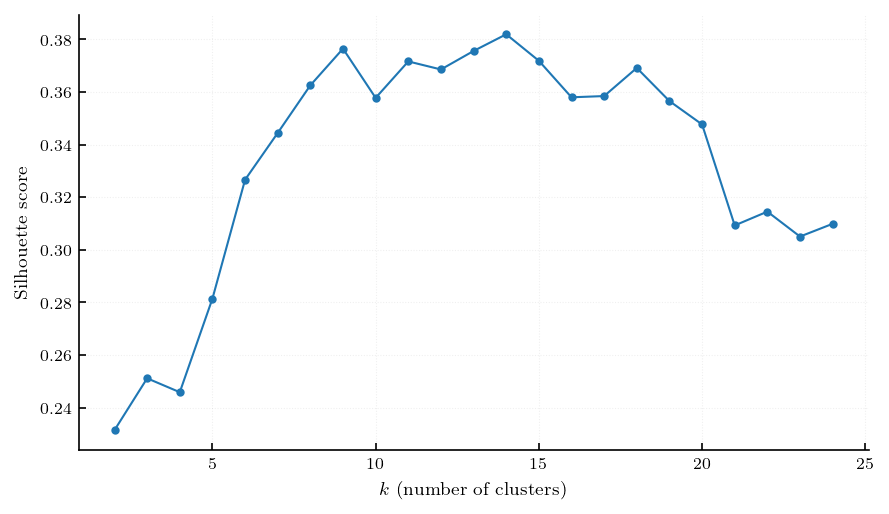

In [ ]:
k_values = sorted(sil_scores.keys())
sil_values = [sil_scores[k] for k in k_values]

fig, ax = nice_axes(figsize=(6, 3.5))

ax.plot(k_values, sil_values, marker="o")

ax.set_xlabel(r"$k$ (number of clusters)")
ax.set_ylabel(r"Silhouette score")

ax.grid(alpha=0.2, linestyle=":", linewidth=0.5)

fig.tight_layout()
fig.savefig("silhouette.pdf")
plt.show()

In [ ]:
cluster_labels = best_labels

ari = adjusted_rand_score(y_test_true, cluster_labels)
nmi = normalized_mutual_info_score(y_test_true, cluster_labels)

# Print diagnostics for the selected k
print(f"KMeans best k = {best_k}")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

KMeans best k = 14
Adjusted Rand Index (ARI): 0.8028
Normalized Mutual Information (NMI): 0.9098


cm shape (true classes x clusters): (12, 14)


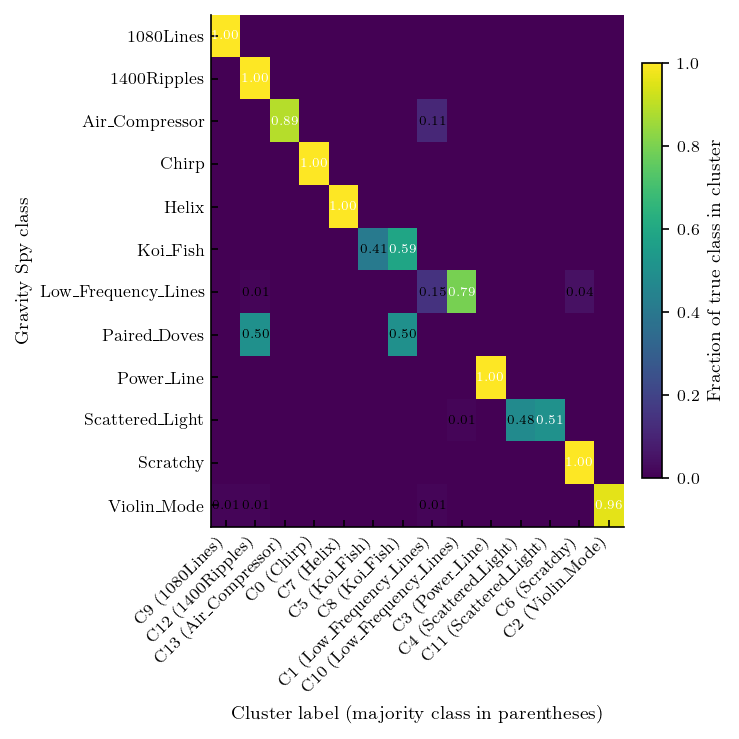

In [ ]:
num_classes = len(idx_to_label)
k = best_k   # number of clusters

# Rows = true classes, columns = clusters
cm = np.zeros((num_classes, k), dtype=int)

for c in range(num_classes):
    for cl in range(k):
        cm[c, cl] = np.sum((y_test_true == c) & (cluster_labels == cl))

print("cm shape (true classes x clusters):", cm.shape)

row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = cm.astype(float) / np.maximum(row_sums, 1)

# For each cluster, find which class it mostly contains
cluster_majority_class = []
for cl in range(k):
    counts = cm[:, cl]              # counts of each true class inside cluster cl
    maj_class = int(np.argmax(counts))
    cluster_majority_class.append(maj_class)

# Sort clusters by majority class index (secondary key = cluster id)
sorted_clusters = sorted(range(k), key=lambda cl: (cluster_majority_class[cl], cl))

# Reorder columns
cm_norm_reordered = cm_norm[:, sorted_clusters]
cm_counts_reordered = cm[:, sorted_clusters]

class_names = [idx_to_label[i] for i in range(num_classes)]

x_labels = [
    f"C{cl} ({idx_to_label[cluster_majority_class[cl]]})"
    for cl in sorted_clusters
]
y_labels = class_names

fig, ax = nice_axes(figsize=(5, 5))

im = ax.imshow(
    cm_norm_reordered,
    cmap="viridis",
    vmin=0.0,
    vmax=1.0,
    aspect="auto",
    interpolation="none",
)

# Ticks
ax.set_xticks(np.arange(k))
ax.set_yticks(np.arange(num_classes))

# Escape underscores for LaTeX (if any)
x_ticklabels = [lbl.replace("_", r"\_") for lbl in x_labels]
y_ticklabels = [lbl.replace("_", r"\_") for lbl in y_labels]

ax.set_xticklabels(x_ticklabels, rotation=45, ha="right")
ax.set_yticklabels(y_ticklabels)

ax.set_xlabel(r"Cluster label (majority class in parentheses)")
ax.set_ylabel(r"Gravity Spy class")

# Colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r"Fraction of true class in cluster")

# Annotate each cell with its value
for i in range(num_classes):
    for j in range(k):
        val = cm_norm_reordered[i, j]
        if val < 1e-4:
            continue  # skip tiny zeros to avoid clutter
        text_color = "white" if val > 0.5 else "black"
        ax.text(
            j,
            i,
            f"{val:.2f}",
            ha="center",
            va="center",
            color=text_color,
            fontsize=6,
        )

fig.tight_layout()
fig.savefig("confusion_matrix.pdf")
plt.show()

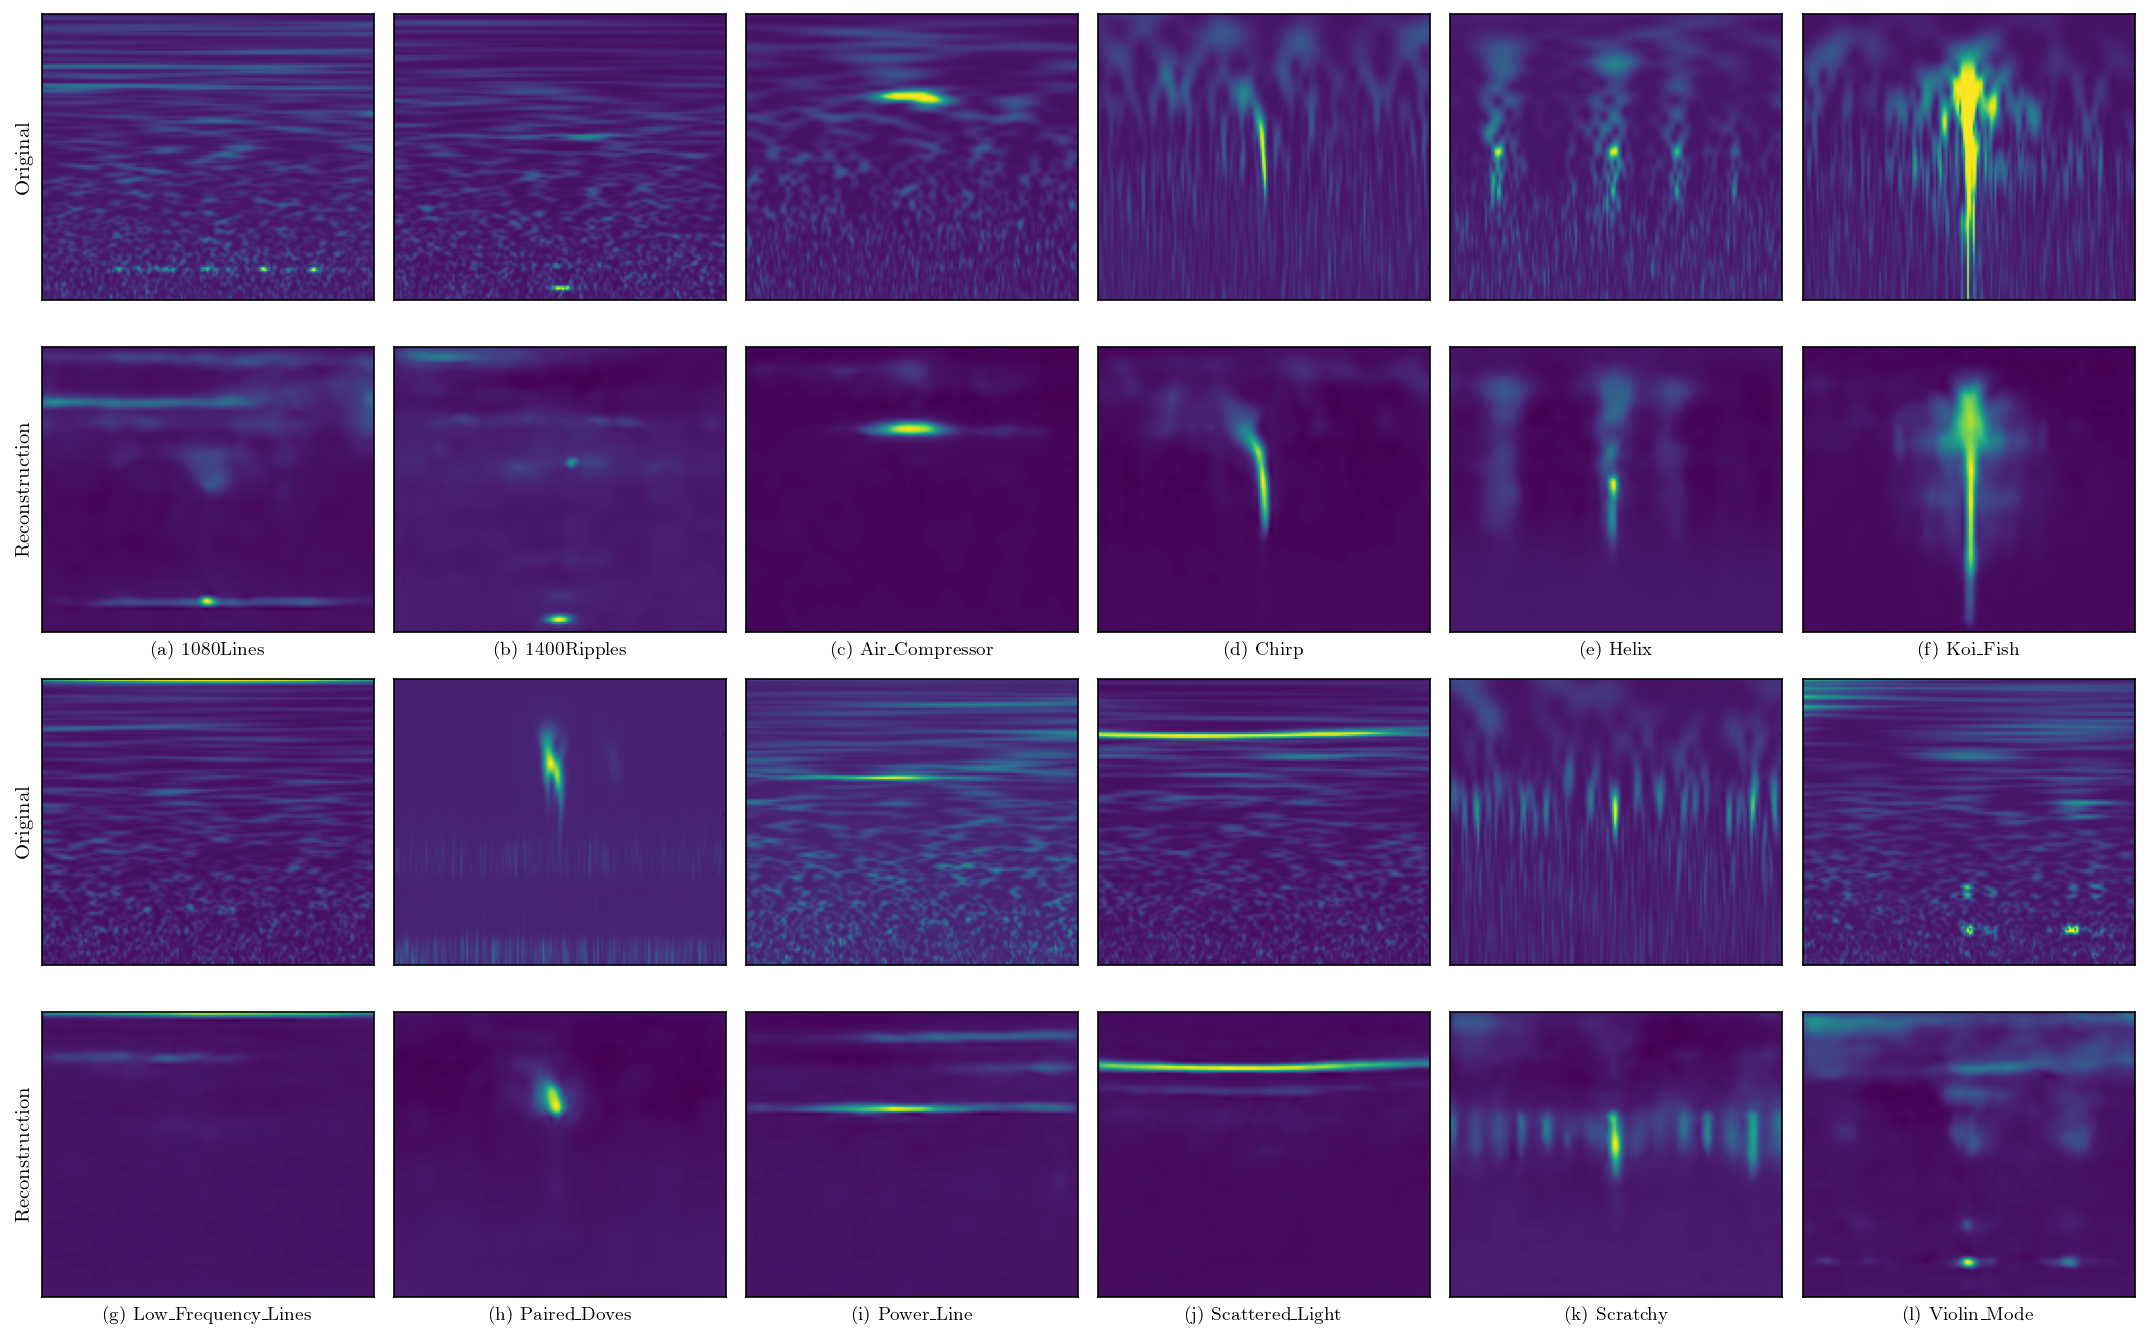

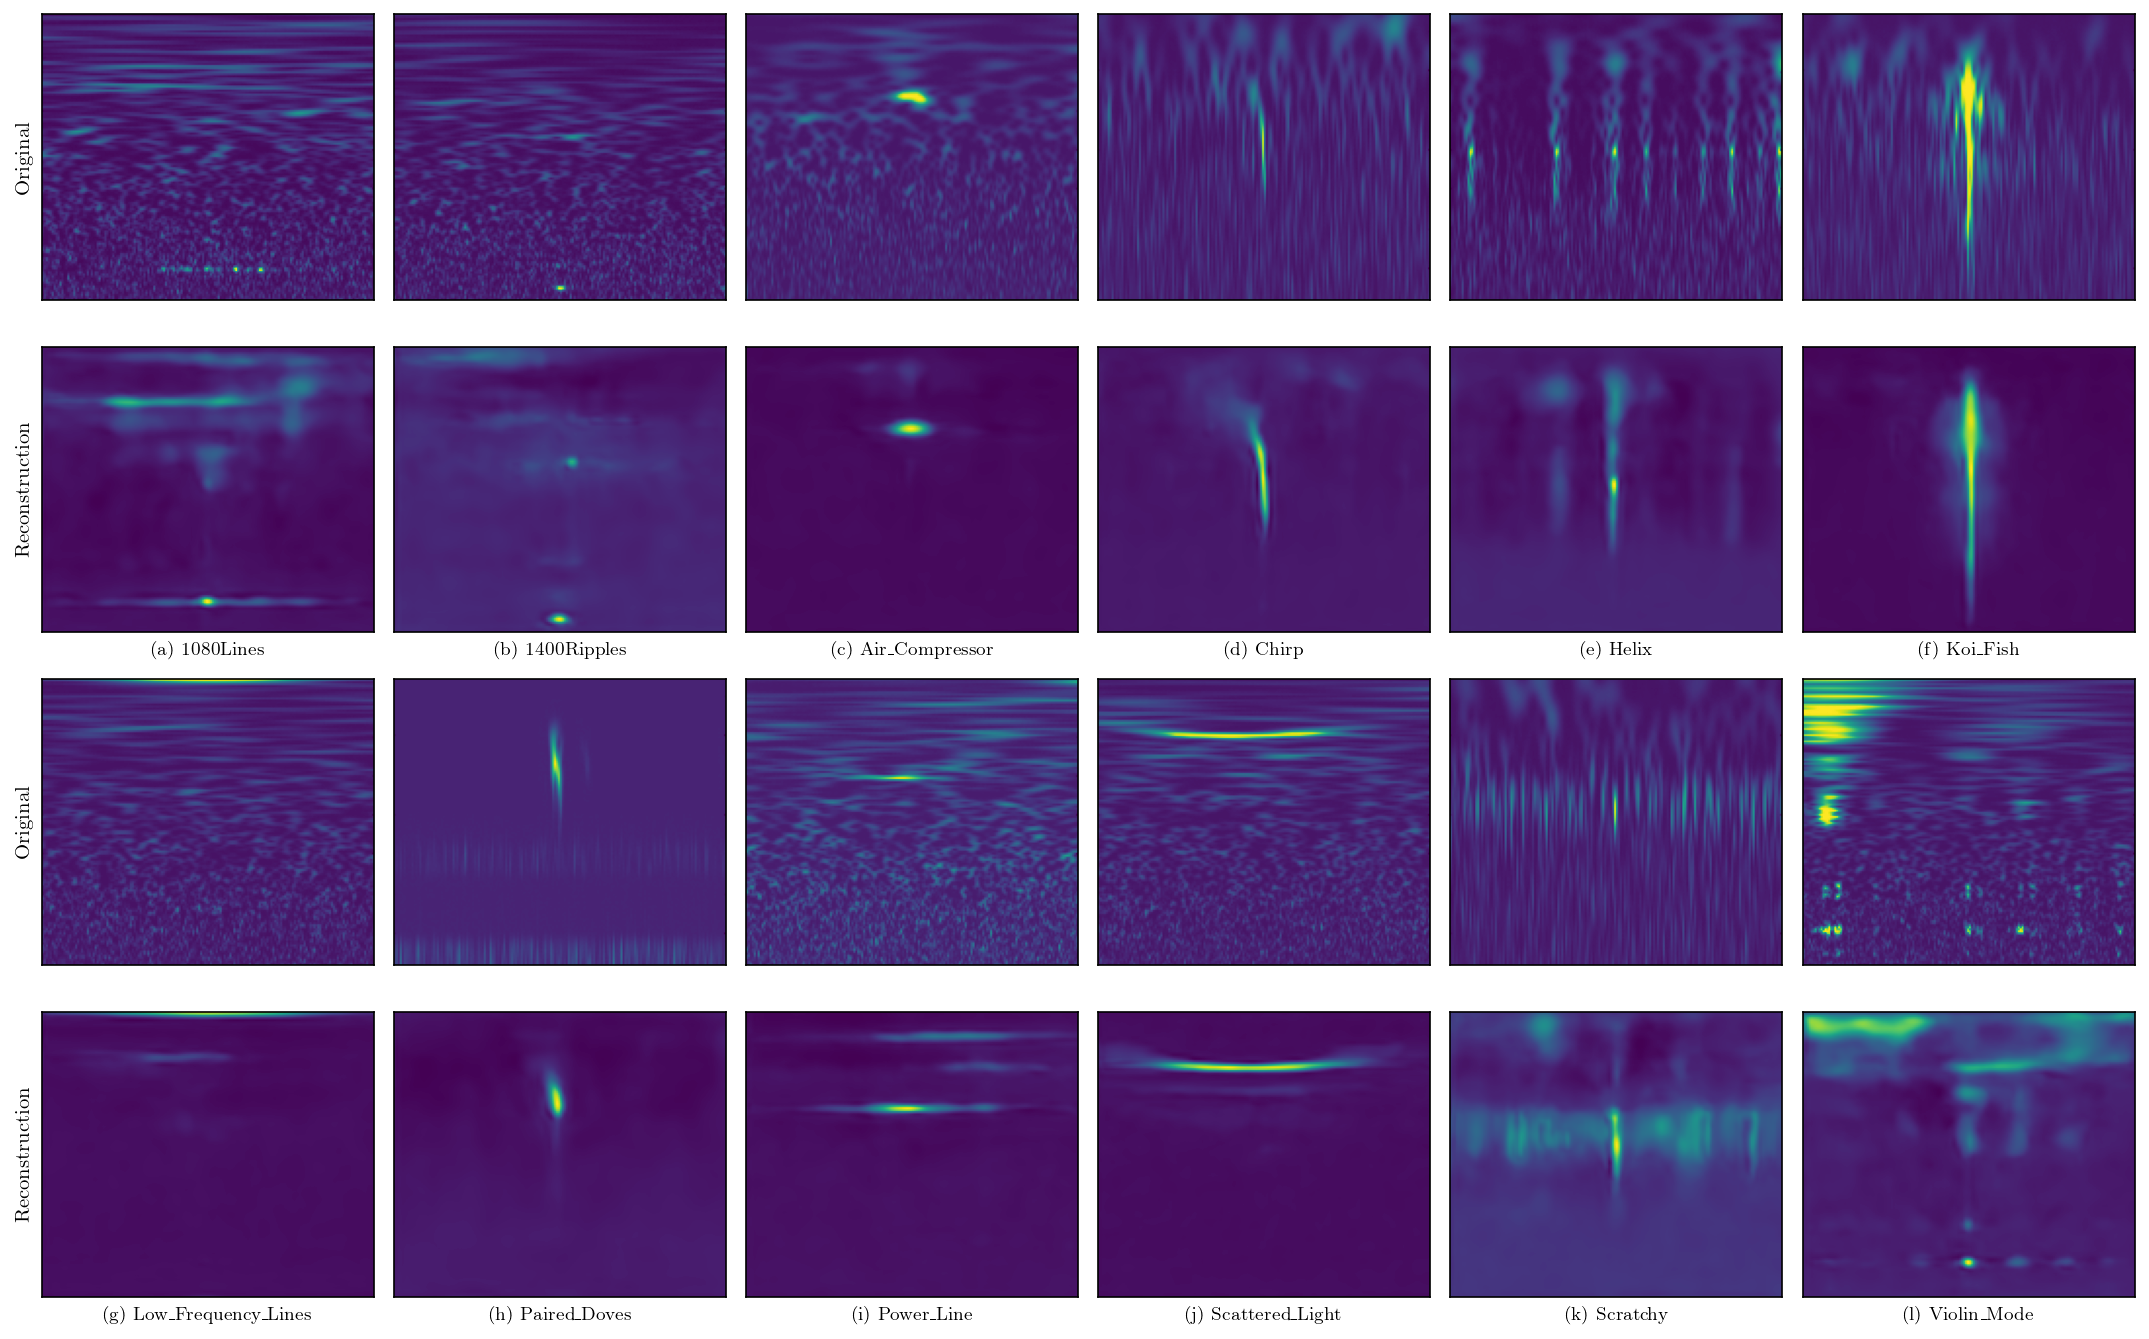

In [ ]:
# ----- 1. Choose one test sample per class -----
X_plot = X_test            # (N_test, C, H, W)
y_plot_idx = y_test_idx    # (N_test,)

num_classes = len(idx_to_label)

# For each class index, pick the first example in the test set
class_indices = []
classes_present = []
for cls in range(num_classes):
    idxs = np.where(y_plot_idx == cls)[0]
    if len(idxs) == 0:
        continue
    class_indices.append(idxs[0])
    classes_present.append(cls)

K = len(classes_present)
X_sel = X_plot[class_indices]          # (K, C, H, W)

# ----- 2. Run them through the model to get reconstructions -----
model.eval()
with torch.no_grad():
    xb = torch.from_numpy(X_sel).to(device, dtype=torch.float32)
    out = model(xb)
    if isinstance(out, tuple) and len(out) == 3:
        x_hat, _, _ = out
    else:
        x_hat, _ = out

    xb_np    = xb.cpu().numpy()
    x_hat_np = x_hat.cpu().numpy()

K, C, H, W = xb_np.shape

# ----- 3. Helper to plot one channel in 4x6 grid -----
def plot_reconstructions_for_channel(channel_idx):
    """
    channel_idx: which duration channel (0 or 1)
    Layout: 4 rows x 6 columns, captions under reconstructions.
    """

    classes_per_row = 6
    n_class_rows = 2
    n_rows = n_class_rows * 2
    n_cols = classes_per_row

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(2.4 * n_cols, 4.5 * n_class_rows),
        squeeze=False
    )

    letters = list(string.ascii_lowercase)

    for idx, cls in enumerate(classes_present):
        cls_name = idx_to_label[cls]
        letter = letters[idx] if idx < len(letters) else f"{idx}"

        # Determine which block this class goes to
        block_row = idx // classes_per_row       # 0 or 1
        col = idx % classes_per_row

        orig_row = 2 * block_row
        rec_row  = 2 * block_row + 1

        orig = xb_np[idx, channel_idx]      # (H, W)
        recon = x_hat_np[idx, channel_idx]  # (H, W)

        ax_orig = axes[orig_row, col]
        ax_rec  = axes[rec_row,  col]

        ax_orig.imshow(orig, aspect="auto", origin="lower", cmap="viridis")
        ax_rec.imshow(recon, aspect="auto", origin="lower", cmap="viridis")

        ax_rec.set_xlabel(f"({letter}) {cls_name}", fontsize=9, labelpad=4)

        ax_orig.set_xticks([])
        ax_orig.set_yticks([])
        ax_rec.set_xticks([])
        ax_rec.set_yticks([])

        if col == 0:
            ax_orig.set_ylabel("Original", fontsize=10)
            ax_rec.set_ylabel("Reconstruction", fontsize=10)

    plt.tight_layout()
    plt.show()

plot_reconstructions_for_channel(channel_idx=0)
plot_reconstructions_for_channel(channel_idx=1)

In [ ]:
# ---- UMAP to 2D ----
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42,
)
embs_2d = reducer.fit_transform(embs_std)   # (N, 2)

/home/sparmagkos/miniconda3/envs/gravityspy/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/tmp/ipykernel_8128/2447525373.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_labels = plt.cm.get_cmap("tab20", num_classes)  # distinct color per class


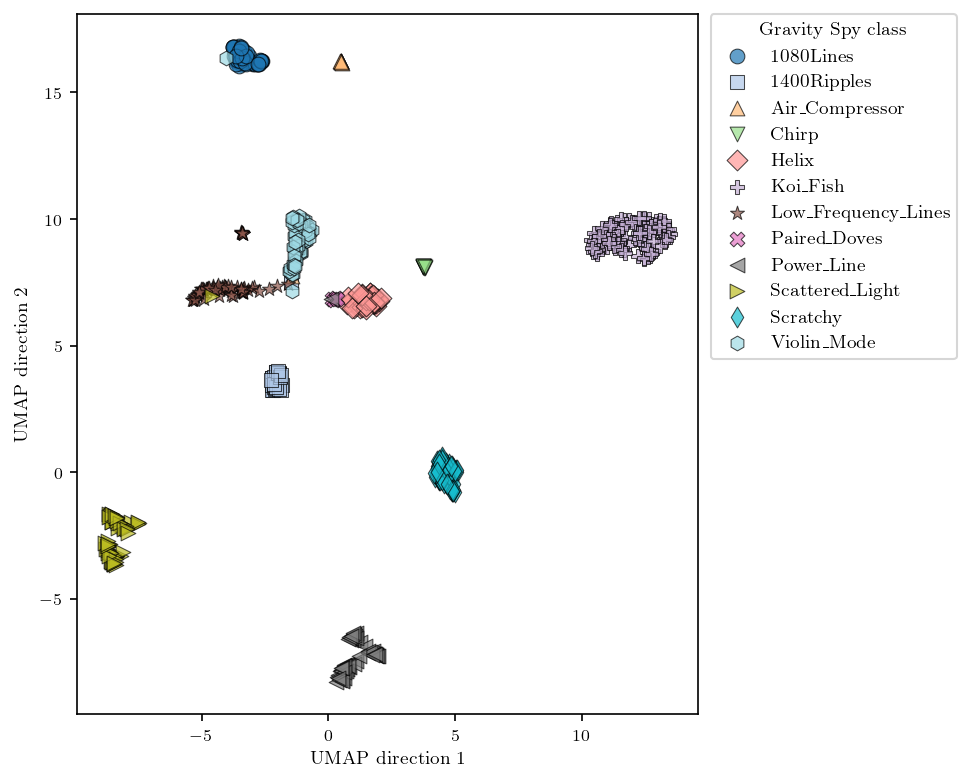

In [ ]:
num_classes = len(idx_to_label)
cmap_labels = plt.cm.get_cmap("tab20", num_classes)

markers = ['o', 's', '^', 'v', 'D', 'P', '*', 'X', '<', '>', 'd', 'h']

fig, ax = plt.subplots(figsize=(6, 6))

for cls_idx in range(num_classes):
    mask = (y_test_true == cls_idx)
    if not np.any(mask):
        continue

    marker = markers[cls_idx % len(markers)]

    ax.scatter(
        embs_2d[mask, 0],
        embs_2d[mask, 1],
        s=50,
        color=cmap_labels(cls_idx),
        marker=marker,
        label=idx_to_label[cls_idx],
        alpha=0.7,
        edgecolors="k",
        linewidths=0.5
    )

ax.set_xlabel("UMAP direction 1")
ax.set_ylabel("UMAP direction 2")
ax.set_aspect("equal", "box")

ax.legend(
    title="Gravity Spy class",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0.,
    fontsize=9,
)

plt.tight_layout()
plt.show()
fig.savefig("umap1.pdf")

/tmp/ipykernel_8128/3756207499.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_clusters = plt.cm.get_cmap("tab20", k_clusters)


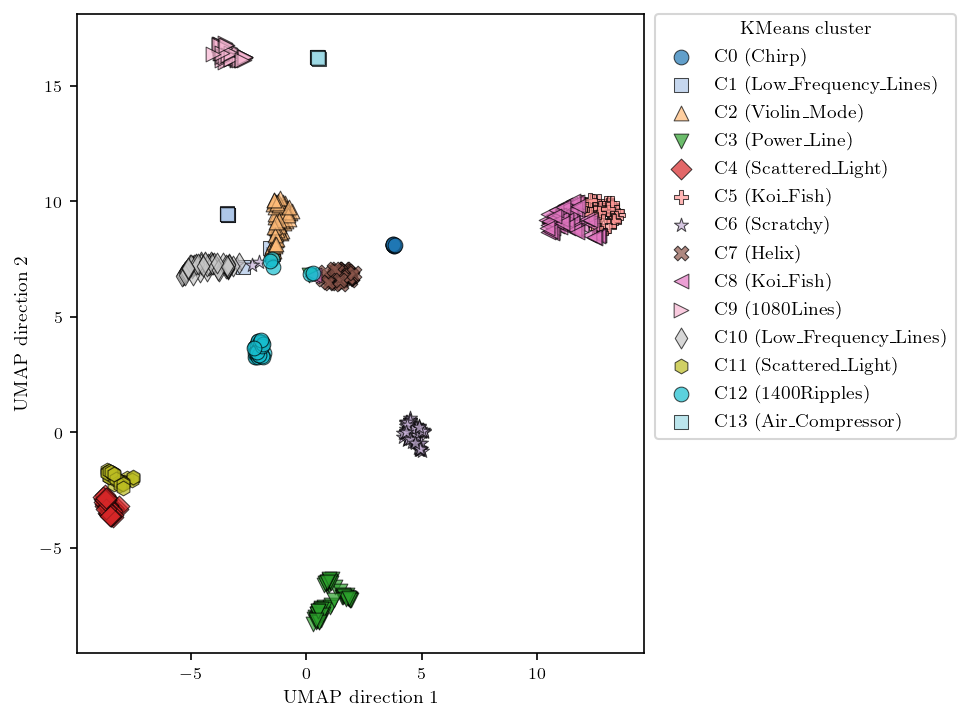

In [ ]:
k_clusters = best_k

# Majority Gravity Spy label per cluster
majority_labels = []
for c in range(k_clusters):
    mask = (cluster_labels == c)
    if np.any(mask):
        labels_in_cluster = y_test_true[mask]
        vals, counts = np.unique(labels_in_cluster, return_counts=True)
        majority_class_idx = vals[np.argmax(counts)]
        majority_labels.append(idx_to_label[majority_class_idx])
    else:
        majority_labels.append("None")

cmap_clusters = plt.cm.get_cmap("tab20", k_clusters)
markers = ['o', 's', '^', 'v', 'D', 'P', '*', 'X', '<', '>', 'd', 'h']

fig, ax = plt.subplots(figsize=(6, 6))

for c in range(k_clusters):
    mask = (cluster_labels == c)
    if not np.any(mask):
        continue

    marker = markers[c % len(markers)]

    ax.scatter(
        embs_2d[mask, 0],
        embs_2d[mask, 1],
        s=50,
        color=cmap_clusters(c),
        marker=marker,
        label=f"C{c} ({majority_labels[c]})",
        alpha=0.7,
        edgecolors="k",
        linewidths=0.5
    )

ax.set_xlabel("UMAP direction 1")
ax.set_ylabel("UMAP direction 2")
ax.set_aspect("equal", "box")

ax.legend(
    title="KMeans cluster",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0.,
    fontsize=9,
)

plt.tight_layout()
plt.show()
fig.savefig("umap2.pdf")